<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/HydroWizard_Intelligent_Fuzzy_Logic_Irrigation/blob/master/HydroWizard_Intelligent_Fuzzy_Logic_Irrigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HydroWizard_Intelligent_Fuzzy_Logic_Irrigation**

## **Libraries**

In [2]:
!pip install scikit-fuzzy

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from skfuzzy.defuzzify import defuzz
import matplotlib.pyplot as plt

## **Membership Functions**

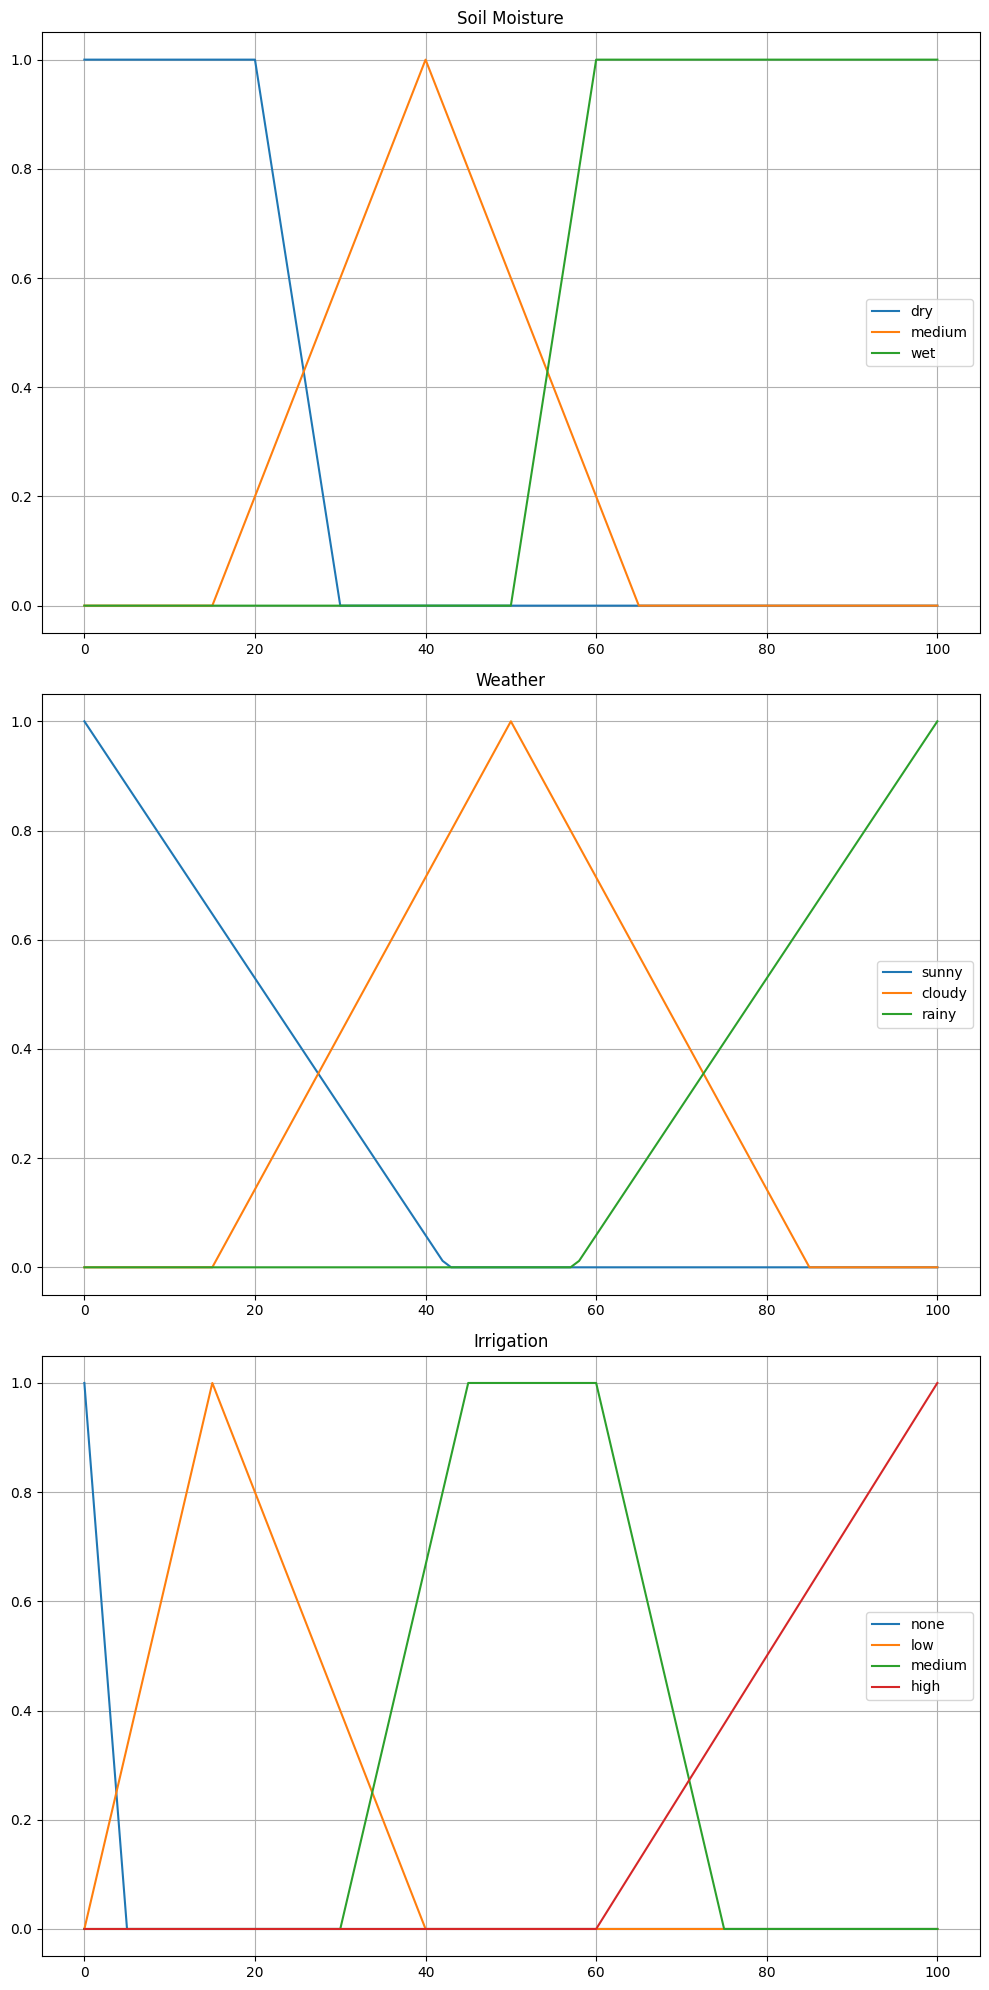

In [49]:
# Define the range of each variable (from 0 to 100)
soil_moisture = np.arange(0, 101, 1)
weather_range = np.arange(0, 101, 1)
irrigation_range = np.arange(0, 101, 1)

# Define fuzzy variables
soil = ctrl.Antecedent(soil_moisture, 'soil')
weather = ctrl.Antecedent(weather_range, 'weather')
irrigation = ctrl.Consequent(irrigation_range, 'irrigation')

# Membership functions for soil
soil['dry'] = fuzz.trapmf(soil.universe, [-1, 0, 20, 30])
soil['medium'] = fuzz.trimf(soil.universe, [15, 40, 65])
soil['wet'] = fuzz.trapmf(soil.universe, [50, 60, 100, 101])

# Membership functions for weather
weather['sunny'] = fuzz.trimf(weather.universe, [0, 0, 42.5])
weather['cloudy'] = fuzz.trimf(weather.universe, [15, 50, 85])
weather['rainy'] = fuzz.trimf(weather.universe, [57.5, 100, 100])

# Membership functions for irrigation
irrigation['none'] = fuzz.trimf(irrigation.universe, [-1, 0, 5])
irrigation['low'] = fuzz.trimf(irrigation.universe, [0, 15, 40])
irrigation['medium'] = fuzz.trapmf(irrigation.universe, [30, 45, 60, 75])
irrigation['high'] = fuzz.trimf(irrigation.universe, [60, 100, 101])

def plot_mf(var, var_name, ax):
    for label in var.terms:
        mf = var.terms[label].mf
        ax.plot(var.universe, mf, label=label)
    ax.set_title(var_name)
    ax.legend()
    ax.grid(True)

# Plotting the fuzzy sets
fig, axs = plt.subplots(nrows=3, figsize=(10, 20))
# axs = axs.flatten()

plot_mf(soil, 'Soil Moisture', axs[0]) # Plot fuzzy sets for soil moisture
plot_mf(weather, 'Weather', axs[1]) # Plot fuzzy sets for weather
plot_mf(irrigation, 'Irrigation', axs[2]) # Plot fuzzy sets for irrigation

plt.tight_layout()
plt.show()

## **Control Rules and Defuzzification**

### **Fuzzy Logic Rules**

In [50]:
# Define fuzzy rules based on the given chart
rule1 = ctrl.Rule(soil['dry'] & weather['sunny'], irrigation['high'])
rule2 = ctrl.Rule(soil['dry'] & weather['cloudy'], irrigation['medium'])
rule3 = ctrl.Rule(soil['dry'] & weather['rainy'], irrigation['low'])

rule4 = ctrl.Rule(soil['medium'] & weather['sunny'], irrigation['medium'])
rule5 = ctrl.Rule(soil['medium'] & weather['cloudy'], irrigation['low'])
rule6 = ctrl.Rule(soil['medium'] & weather['rainy'], irrigation['none'])

rule7 = ctrl.Rule(soil['wet'] & weather['sunny'], irrigation['low'])
rule8 = ctrl.Rule(soil['wet'] & weather['cloudy'], irrigation['none'])
rule9 = ctrl.Rule(soil['wet'] & weather['rainy'], irrigation['none'])

### **Control Rules**

In [51]:
# Create the control system and simulation
irrigation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
irrigation_sim = ctrl.ControlSystemSimulation(irrigation_ctrl)

### **Defuzzification**

#### **Membership Level Of Entries**

In [52]:
def input_value(soil_val=30, weather_val=20):
    return soil_val, weather_val

soil_val, weather_val = input_value()

μ_soil_dry = fuzz.interp_membership(soil.universe, soil['dry'].mf, soil_val)
μ_soil_medium = fuzz.interp_membership(soil.universe, soil['medium'].mf, soil_val)
μ_soil_wet = fuzz.interp_membership(soil.universe, soil['wet'].mf, soil_val)

μ_weather_sunny = fuzz.interp_membership(weather.universe, weather['sunny'].mf, weather_val)
μ_weather_cloudy = fuzz.interp_membership(weather.universe, weather['cloudy'].mf, weather_val)
μ_weather_rainy = fuzz.interp_membership(weather.universe, weather['rainy'].mf, weather_val)

print("Soil Membership Degrees:")
print(f"  Dry:    {μ_soil_dry:.2f}")
print(f"  Medium: {μ_soil_medium:.2f}")
print(f"  Wet:    {μ_soil_wet:.2f}")

print("Weather Membership Degrees:")
print(f"  Sunny:  {μ_weather_sunny:.2f}")
print(f"  Cloudy: {μ_weather_cloudy:.2f}")
print(f"  Rainy:  {μ_weather_rainy:.2f}")

Soil Membership Degrees:
  Dry:    0.00
  Medium: 0.60
  Wet:    0.00
Weather Membership Degrees:
  Sunny:  0.53
  Cloudy: 0.14
  Rainy:  0.00


#### **Activation Rules**

In [53]:
activation_rule1 = np.fmin(μ_soil_dry, μ_weather_sunny)     # → irrigation high
activation_rule2 = np.fmin(μ_soil_dry, μ_weather_cloudy)    # → irrigation medium
activation_rule3 = np.fmin(μ_soil_dry, μ_weather_rainy)     # → irrigation low

activation_rule4 = np.fmin(μ_soil_medium, μ_weather_sunny)  # → irrigation medium
activation_rule5 = np.fmin(μ_soil_medium, μ_weather_cloudy) # → irrigation low
activation_rule6 = np.fmin(μ_soil_medium, μ_weather_rainy)  # → irrigation none

activation_rule7 = np.fmin(μ_soil_wet, μ_weather_sunny)     # → irrigation low
activation_rule8 = np.fmin(μ_soil_wet, μ_weather_cloudy)    # → irrigation none
activation_rule9 = np.fmin(μ_soil_wet, μ_weather_rainy)     # → irrigation none

#### **Cutting**

In [54]:
irrigation_high_cut    = np.fmin(activation_rule1, irrigation['high'].mf)
irrigation_medium_cut1 = np.fmin(activation_rule2, irrigation['medium'].mf)
irrigation_medium_cut2 = np.fmin(activation_rule4, irrigation['medium'].mf)
irrigation_low_cut1    = np.fmin(activation_rule3, irrigation['low'].mf)
irrigation_low_cut2    = np.fmin(activation_rule5, irrigation['low'].mf)
irrigation_low_cut3    = np.fmin(activation_rule7, irrigation['low'].mf)
irrigation_none_cut1   = np.fmin(activation_rule6, irrigation['none'].mf)
irrigation_none_cut2   = np.fmin(activation_rule8, irrigation['none'].mf)
irrigation_none_cut3   = np.fmin(activation_rule9, irrigation['none'].mf)

#### **Aggregation**

In [55]:
aggregated_output = np.fmax(
    irrigation_high_cut,
    np.fmax(irrigation_medium_cut1,
    np.fmax(irrigation_medium_cut2,
    np.fmax(irrigation_low_cut1,
    np.fmax(irrigation_low_cut2,
    np.fmax(irrigation_low_cut3,
    np.fmax(irrigation_none_cut1,
    np.fmax(irrigation_none_cut2, irrigation_none_cut3))))))))

#### **Crisp**

##### **Centroid**

In [56]:
crisp_output_centroid = fuzz.defuzz(irrigation.universe, aggregated_output, 'centroid')
print(f"\nFinal Irrigation Output (Centroid): {crisp_output_centroid:.2f}")


Final Irrigation Output (Centroid): 45.97


##### **Visualization**

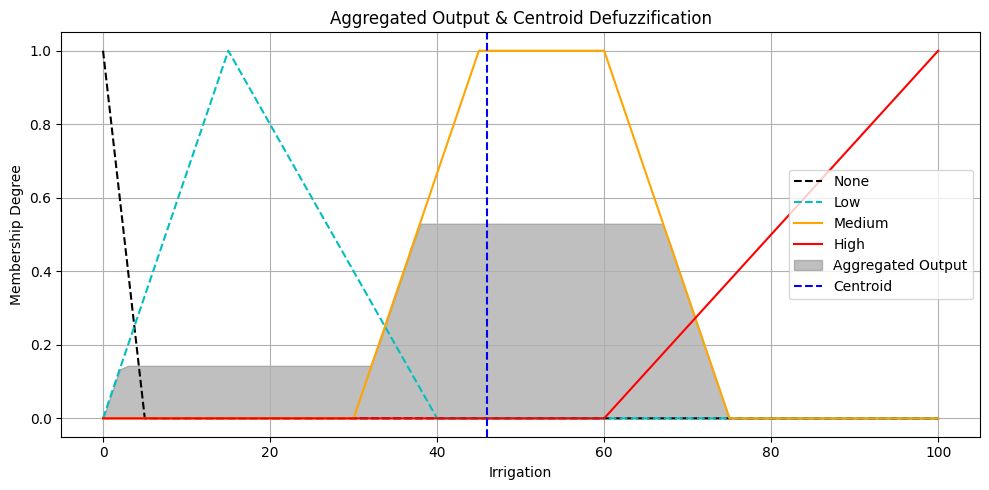

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_centroid, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **First Maximum**

In [58]:
crisp_output_FM = fuzz.defuzz(irrigation.universe, aggregated_output, 'som')
print(f"\nFinal Irrigation Output (First of Maximum): {crisp_output_FM:.2f}")


Final Irrigation Output (First of Maximum): 38.00


##### **Visualization**

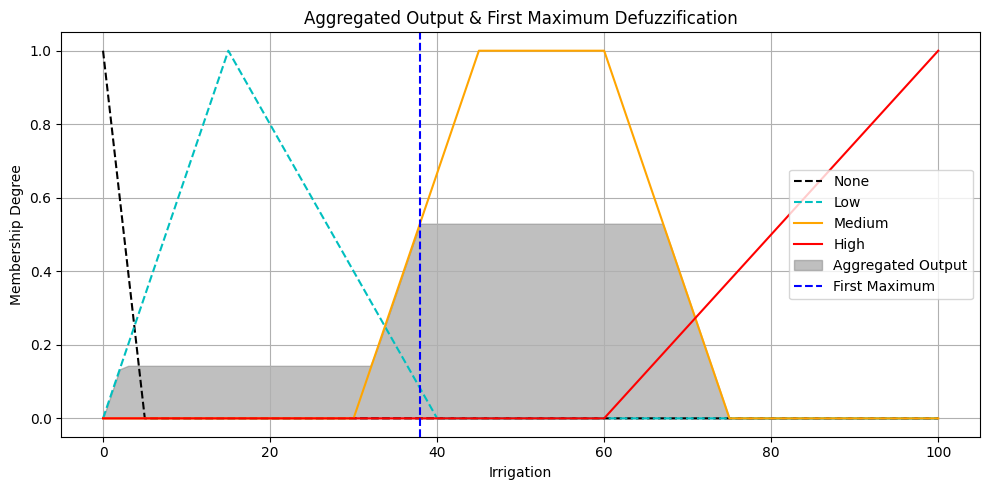

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_FM, color='blue', linestyle='--', label='First Maximum')

plt.title('Aggregated Output & First Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Middle Maximum**

In [60]:
crisp_output_MM = fuzz.defuzz(irrigation.universe, aggregated_output, 'mom')
print(f"\nFinal Irrigation Output (Mean of Maximum): {crisp_output_MM:.2f}")


Final Irrigation Output (Mean of Maximum): 52.50


##### **Visualization**

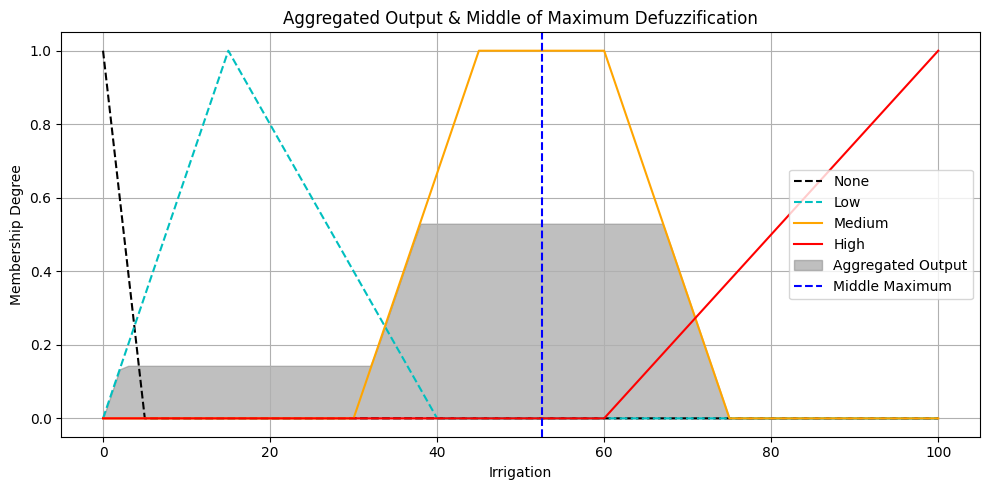

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_MM, color='blue', linestyle='--', label='Middle Maximum')

plt.title('Aggregated Output & Middle of Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Last Maximum**

In [62]:
crisp_output_LM = fuzz.defuzz(irrigation.universe, aggregated_output, 'lom')
print(f"\nFinal Irrigation Output (Last of Maximum): {crisp_output_LM:.2f}")


Final Irrigation Output (Last of Maximum): 67.00


##### **Visualization**

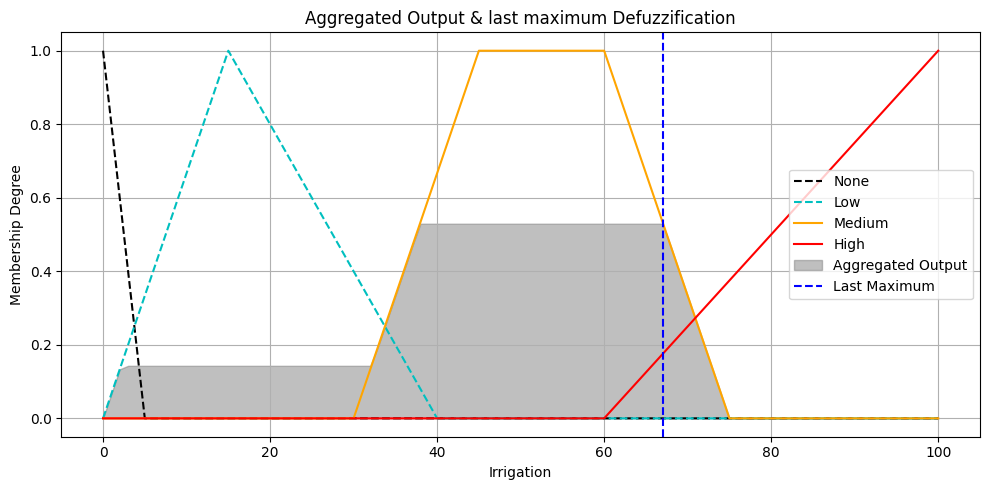

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_LM, color='blue', linestyle='--', label='Last Maximum')

plt.title('Aggregated Output & last maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Center Of The Surface**

In [64]:
crisp_output_bisector = fuzz.defuzz(irrigation.universe, aggregated_output, 'bisector')
print(f"\nFinal Irrigation Output (bisector): {crisp_output_bisector:.2f}")


Final Irrigation Output (bisector): 48.45


##### **Visualization**

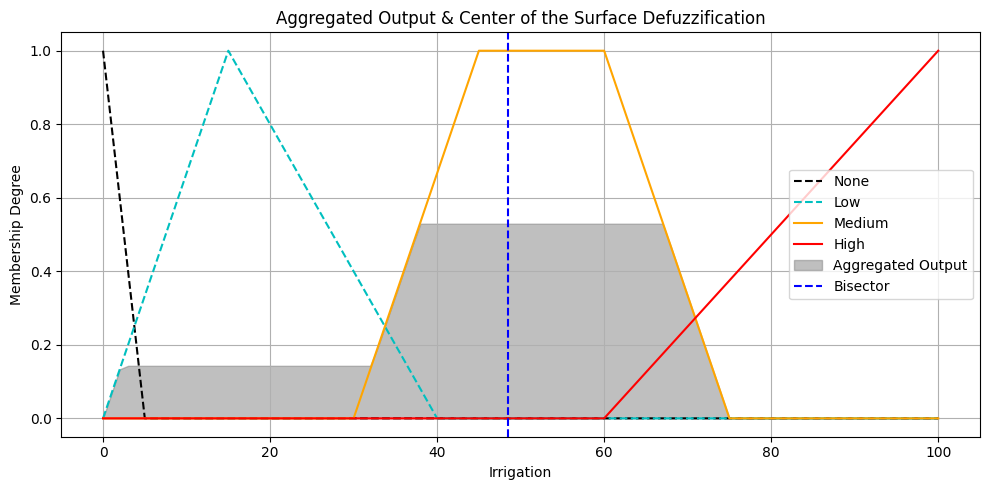

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_bisector, color='blue', linestyle='--', label='Bisector')

plt.title('Aggregated Output & Center of the Surface Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Simulation and Analysis**

### **10 Day Timeframe**

Day 1: Weather=Sunny, Evap=-5.00, Soil Moisture=15.00% → 61.94%, Irrigation=86.56%
Day 2: Weather=Sunny, Evap=-5.00, Soil Moisture=61.94% → 72.70%, Irrigation=26.28%
Day 3: Weather=Cloudy, Evap=-2.00, Soil Moisture=72.70% → 71.79%, Irrigation=1.81%
Day 4: Weather=Rainy, Evap=5.00, Soil Moisture=71.79% → 77.79%, Irrigation=1.67%
Day 5: Weather=Sunny, Evap=-5.00, Soil Moisture=77.79% → 83.80%, Irrigation=18.34%
Day 6: Weather=Cloudy, Evap=-2.00, Soil Moisture=83.80% → 82.81%, Irrigation=1.69%
Day 7: Weather=Rainy, Evap=5.00, Soil Moisture=82.81% → 88.81%, Irrigation=1.67%
Day 8: Weather=Sunny, Evap=-5.00, Soil Moisture=88.81% → 95.02%, Irrigation=18.68%
Day 9: Weather=Cloudy, Evap=-2.00, Soil Moisture=95.02% → 95.90%, Irrigation=4.79%
Day 10: Weather=Rainy, Evap=5.00, Soil Moisture=95.90% → 100.00%, Irrigation=1.69%


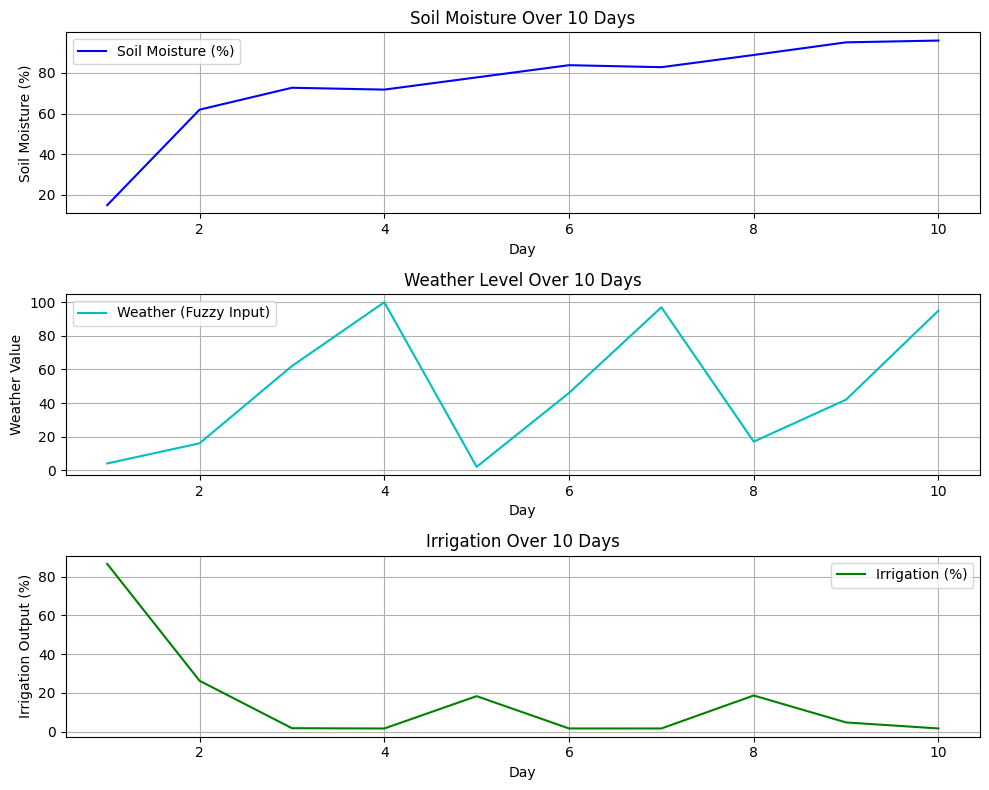

In [66]:
import random

days = 10
soil_moisture_values = [15]  # Initial soil moisture = 15%
weather_fuzzy = ["Sunny", "Sunny", "Cloudy", "Rainy", "Sunny", "Cloudy", "Rainy", "Sunny", "Cloudy", "Rainy"]
weather_values = []
irrigation_values = []

for day in range(days):
    if weather_fuzzy[day] == "Sunny":
        evap = -5
        weather_input = random.randint(0, 30)
    elif weather_fuzzy[day] == "Cloudy":
        evap = -2
        weather_input = random.randint(35, 65)
    else: # weather is rainy
        evap = +5
        weather_input = random.randint(70, 100)


    # Input to the fuzzy system
    soil_input = soil_moisture_values[day]
    weather_values.append(weather_input)

    irrigation_sim.input['soil'] = soil_input
    irrigation_sim.input['weather'] = weather_input
    irrigation_sim.compute()

    irrigation_amount = irrigation_sim.output['irrigation']
    irrigation_values.append(irrigation_amount)

    # Calculating new soil moisture using the modified equation
    new_moisture = soil_input + (irrigation_amount * 0.6) + evap
    new_moisture = np.clip(new_moisture, 0, 100)
    soil_moisture_values.append(new_moisture)

    # Print daily information
    print(f"Day {day+1}: Weather={weather_fuzzy[day]}, Evap={evap:.2f}, Soil Moisture={soil_input:.2f}% → {new_moisture:.2f}%, Irrigation={irrigation_amount:.2f}%")

# Drawing diagrams
days_axis = range(1, days + 1)
plt.figure(figsize=(10, 8))

# Soil moisture
plt.subplot(3, 1, 1)
plt.plot(days_axis, soil_moisture_values[:-1], 'b-', label='Soil Moisture (%)')
plt.title('Soil Moisture Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Soil Moisture (%)')
plt.grid(True)
plt.legend()

# Weather conditions in numbers
plt.subplot(3, 1, 2)
plt.plot(days_axis, weather_values, 'c-', label='Weather (Fuzzy Input)')
plt.title('Weather Level Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Weather Value')
plt.grid(True)
plt.legend()

# Irrigation
plt.subplot(3, 1, 3)
plt.plot(days_axis, irrigation_values, 'g-', label='Irrigation (%)')
plt.title('Irrigation Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Irrigation Output (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### **Analysis and Review**

In [67]:
# Define optimal, under, and over moisture zones
optimal_min = 40
optimal_max = 80

in_range_days = 0
under_moisture_days = 0
over_moisture_days = 0

# Categorize each day's moisture level
for moisture in soil_moisture_values[:-1]:  # Last value is t+1 and unused
    if optimal_min <= moisture <= optimal_max:
        in_range_days += 1
    elif moisture < optimal_min:
        under_moisture_days += 1
    elif moisture > optimal_max:
        over_moisture_days += 1

# Calculate percentages
success_rate = (in_range_days / days) * 100
under_rate = (under_moisture_days / days) * 100
over_rate = (over_moisture_days / days) * 100

# Display full performance analysis
print("\n📊 Detailed Performance Analysis:")
print(f"Optimal Moisture Range: {optimal_min}% to {optimal_max}%")
print(f"Days in Optimal Range: {in_range_days} ({success_rate:.2f}%)")
print(f"Days Under Optimal Range: {under_moisture_days} ({under_rate:.2f}%)")
print(f"Days Over Optimal Range: {over_moisture_days} ({over_rate:.2f}%)")

if over_rate > 40:
    print("This type of irrigation is recommended for greenhouses with high humidity.")
elif under_rate > 20:
    print("This type of irrigation is recommended for greenhouses with low humidity.")
else:
    print("The fuzzy controller maintains soil moisture efficiently within the desired range.")


📊 Detailed Performance Analysis:
Optimal Moisture Range: 40% to 80%
Days in Optimal Range: 4 (40.00%)
Days Under Optimal Range: 1 (10.00%)
Days Over Optimal Range: 5 (50.00%)
This type of irrigation is recommended for greenhouses with high humidity.


## **Increasing Rules and Re-Simulation**

### **Membership Functions**

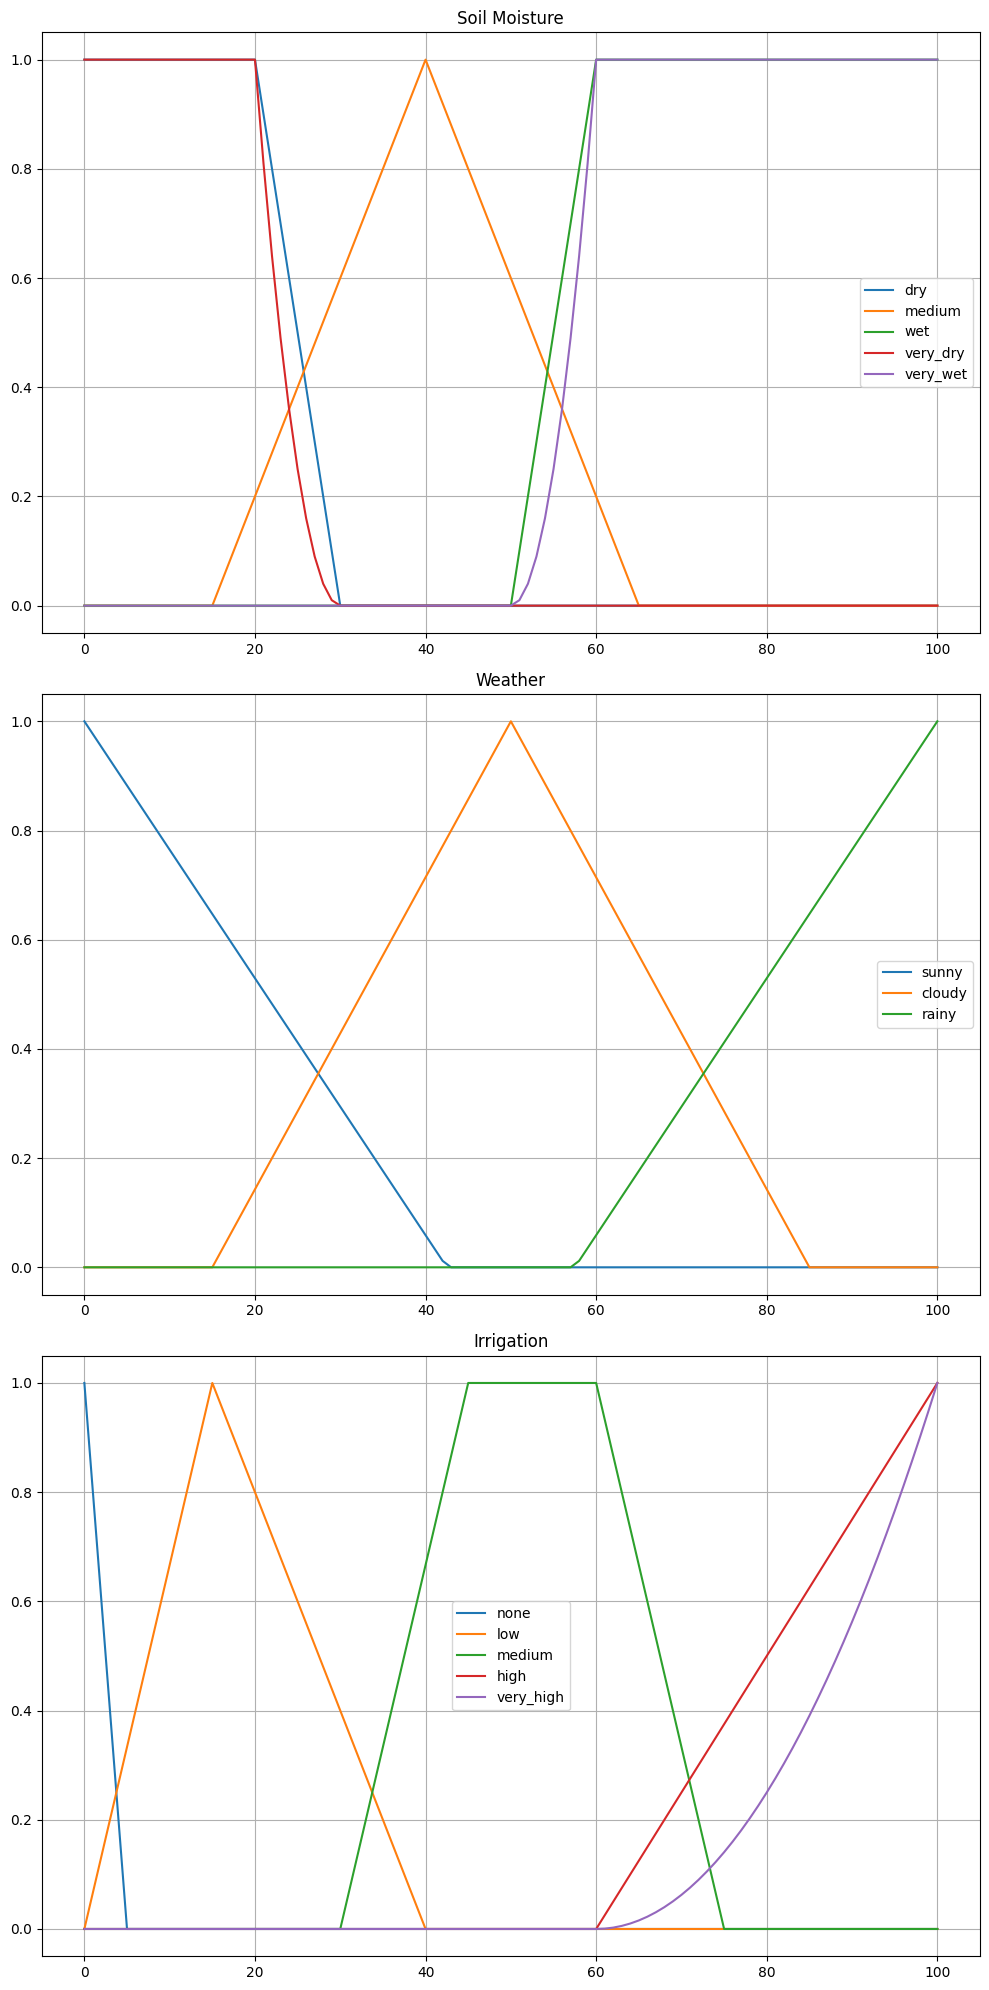

In [68]:
# added membership functions for soil (very dry & very wet) using Concentration (squaring the membership functions)
soil['very_dry'] = np.power(soil['dry'].mf, 2)
soil['very_wet'] = np.power(soil['wet'].mf, 2)

# added membership functions for irrigation (very high)
irrigation['very_high'] = np.power(irrigation['high'].mf, 2)

def plot_mf(var, var_name, ax):
    for label in var.terms:
        mf = var.terms[label].mf
        ax.plot(var.universe, mf, label=label)
    ax.set_title(var_name)
    ax.legend()
    ax.grid(True)

# Plotting the fuzzy sets
fig, axs = plt.subplots(nrows=3, figsize=(10, 20))
# axs = axs.flatten()

plot_mf(soil, 'Soil Moisture', axs[0]) # Plot fuzzy sets for soil moisture
plot_mf(weather, 'Weather', axs[1]) # Plot fuzzy sets for weather
plot_mf(irrigation, 'Irrigation', axs[2]) # Plot fuzzy sets for irrigation

plt.tight_layout()
plt.show()

### **Control Rules and Defuzzification**

#### **Fuzzy Logic Rules**

In [69]:
# Adding new rules using new variables
rule10 = ctrl.Rule(soil['very_dry'] & weather['sunny'], irrigation['very_high'])
rule11 = ctrl.Rule(soil['very_dry'] & weather['cloudy'], irrigation['high'])
rule12 = ctrl.Rule(soil['very_dry'] & weather['rainy'], irrigation['medium'])
rule13 = ctrl.Rule(soil['very_wet'] & weather['sunny'], irrigation['none'])
rule14 = ctrl.Rule(soil['very_wet'] & weather['cloudy'], irrigation['none'])
rule15 = ctrl.Rule(soil['very_wet'] & weather['rainy'], irrigation['none'])

#### **Control Rules**

In [70]:
# Create the control system and simulation
irrigation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15])
irrigation_sim = ctrl.ControlSystemSimulation(irrigation_ctrl)

#### **Defuzzification**

##### **Membership Level Of Entries**

In [71]:
def input_value(soil_val=25, weather_val=20):
    return soil_val, weather_val

soil_val, weather_val = input_value()

μ_soil_very_dry = fuzz.interp_membership(soil.universe, soil['very_dry'].mf, soil_val)
μ_soil_dry = fuzz.interp_membership(soil.universe, soil['dry'].mf, soil_val)
μ_soil_medium = fuzz.interp_membership(soil.universe, soil['medium'].mf, soil_val)
μ_soil_wet = fuzz.interp_membership(soil.universe, soil['wet'].mf, soil_val)
μ_soil_very_wet = fuzz.interp_membership(soil.universe, soil['very_wet'].mf, soil_val)

μ_weather_sunny = fuzz.interp_membership(weather.universe, weather['sunny'].mf, weather_val)
μ_weather_cloudy = fuzz.interp_membership(weather.universe, weather['cloudy'].mf, weather_val)
μ_weather_rainy = fuzz.interp_membership(weather.universe, weather['rainy'].mf, weather_val)

print("Soil Membership Degrees:")
print(f"  Very Dry:    {μ_soil_very_dry:.2f}")
print(f"  Dry:         {μ_soil_dry:.2f}")
print(f"  Medium:      {μ_soil_medium:.2f}")
print(f"  Wet:         {μ_soil_wet:.2f}")
print(f"  Very Wet:    {μ_soil_very_wet:.2f}")

print("Weather Membership Degrees:")
print(f"  Sunny:  {μ_weather_sunny:.2f}")
print(f"  Cloudy: {μ_weather_cloudy:.2f}")
print(f"  Rainy:  {μ_weather_rainy:.2f}")

Soil Membership Degrees:
  Very Dry:    0.25
  Dry:         0.50
  Medium:      0.40
  Wet:         0.00
  Very Wet:    0.00
Weather Membership Degrees:
  Sunny:  0.53
  Cloudy: 0.14
  Rainy:  0.00


##### **Activation Rules**

In [72]:
activation_rule10 = np.fmin(μ_soil_very_dry, μ_weather_sunny)     # → irrigation very high
activation_rule11 = np.fmin(μ_soil_very_dry, μ_weather_cloudy)    # → irrigation high
activation_rule12 = np.fmin(μ_soil_very_dry, μ_weather_rainy)     # → irrigation medium

activation_rule13 = np.fmin(μ_soil_very_wet, μ_weather_sunny)     # → irrigation none
activation_rule14 = np.fmin(μ_soil_very_wet, μ_weather_cloudy)    # → irrigation none
activation_rule15 = np.fmin(μ_soil_very_wet, μ_weather_rainy)     # → irrigation none

##### **Cutting**

In [73]:
irrigation_very_high_cut = np.fmin(activation_rule10,  irrigation['very_high'].mf)
irrigation_high_cut1   = np.fmin(activation_rule1, irrigation['high'].mf)
irrigation_high_cut2   = np.fmin(activation_rule11,  irrigation['high'].mf)
irrigation_medium_cut1 = np.fmin(activation_rule2, irrigation['medium'].mf)
irrigation_medium_cut2 = np.fmin(activation_rule4, irrigation['medium'].mf)
irrigation_medium_cut3 = np.fmin(activation_rule12,  irrigation['medium'].mf)
irrigation_low_cut1    = np.fmin(activation_rule3, irrigation['low'].mf)
irrigation_low_cut2    = np.fmin(activation_rule5, irrigation['low'].mf)
irrigation_low_cut3    = np.fmin(activation_rule7, irrigation['low'].mf)
irrigation_none_cut1   = np.fmin(activation_rule6, irrigation['none'].mf)
irrigation_none_cut2   = np.fmin(activation_rule8, irrigation['none'].mf)
irrigation_none_cut3   = np.fmin(activation_rule9, irrigation['none'].mf)
irrigation_none_cut4   = np.fmin(activation_rule13, irrigation['none'].mf)
irrigation_none_cut5   = np.fmin(activation_rule14, irrigation['none'].mf)
irrigation_none_cut6   = np.fmin(activation_rule15, irrigation['none'].mf)

##### **Aggregation**

In [74]:
aggregated_output = np.fmax(
    irrigation_very_high_cut,
    np.fmax(irrigation_high_cut1,
    np.fmax(irrigation_high_cut2,
    np.fmax(irrigation_medium_cut1,
    np.fmax(irrigation_medium_cut2,
    np.fmax(irrigation_medium_cut3,
    np.fmax(irrigation_low_cut1,
    np.fmax(irrigation_low_cut2,
    np.fmax(irrigation_low_cut3,
    np.fmax(irrigation_none_cut1,
    np.fmax(irrigation_none_cut2,
    np.fmax(irrigation_none_cut3,
    np.fmax(irrigation_none_cut4,
    np.fmax(irrigation_none_cut5, irrigation_none_cut6))))))))))))))

##### **Crisp**

###### **Centroid**

In [75]:
crisp_output_centroid2 = fuzz.defuzz(irrigation.universe, aggregated_output, 'centroid')
print(f"\nFinal Irrigation Output (Centroid): {crisp_output_centroid2:.2f}")


Final Irrigation Output (Centroid): 54.47


###### **Visualization**

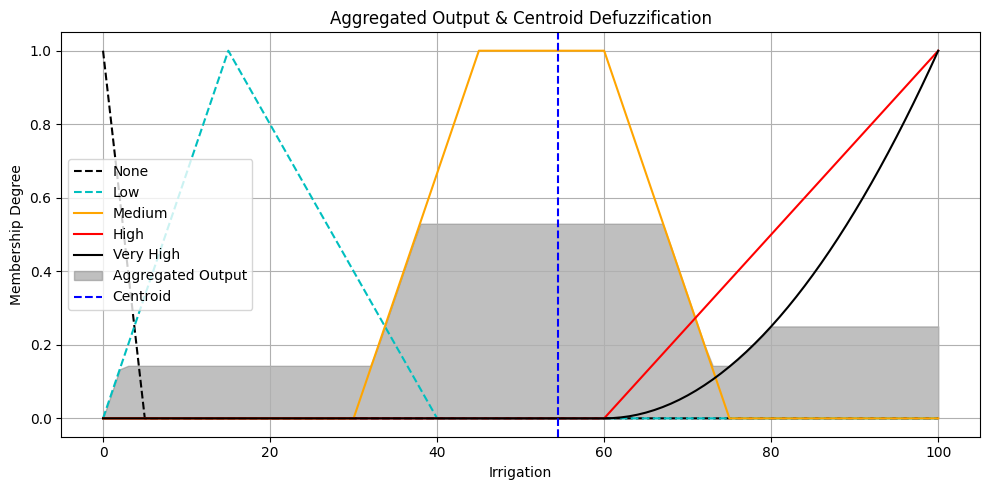

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_centroid2, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### **First Maximum**

In [77]:
crisp_output_FM2 = fuzz.defuzz(irrigation.universe, aggregated_output, 'som')
print(f"\nFinal Irrigation Output (First of Maximum): {crisp_output_FM2:.2f}")


Final Irrigation Output (First of Maximum): 38.00


###### **Visualization**

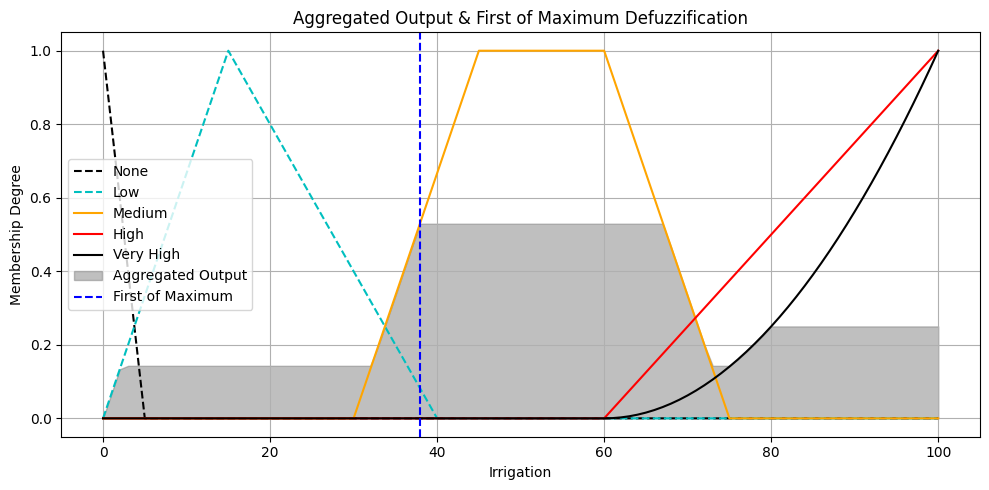

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_FM2, color='blue', linestyle='--', label='First of Maximum')

plt.title('Aggregated Output & First of Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### **Middle Maximum**

In [79]:
crisp_output_MM2 = fuzz.defuzz(irrigation.universe, aggregated_output, 'mom')
print(f"\nFinal Irrigation Output (Mean of Maximum): {crisp_output_MM2:.2f}")


Final Irrigation Output (Mean of Maximum): 52.50


###### **Visualization**

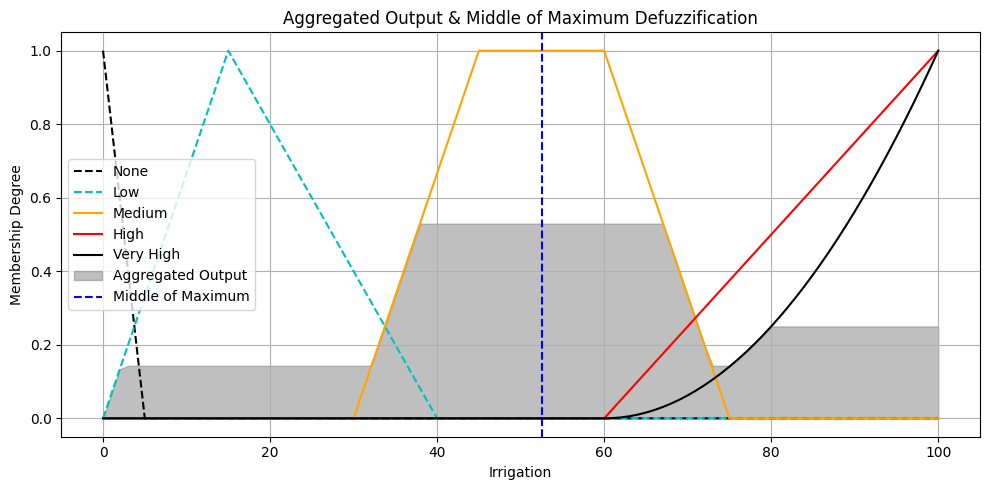

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_MM2, color='blue', linestyle='--', label='Middle of Maximum')

plt.title('Aggregated Output & Middle of Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### **Last Maximum**

In [81]:
crisp_output_LM2 = fuzz.defuzz(irrigation.universe, aggregated_output, 'lom')
print(f"\nFinal Irrigation Output (Last of Maximum): {crisp_output_LM2:.2f}")


Final Irrigation Output (Last of Maximum): 67.00


###### **Visualization**

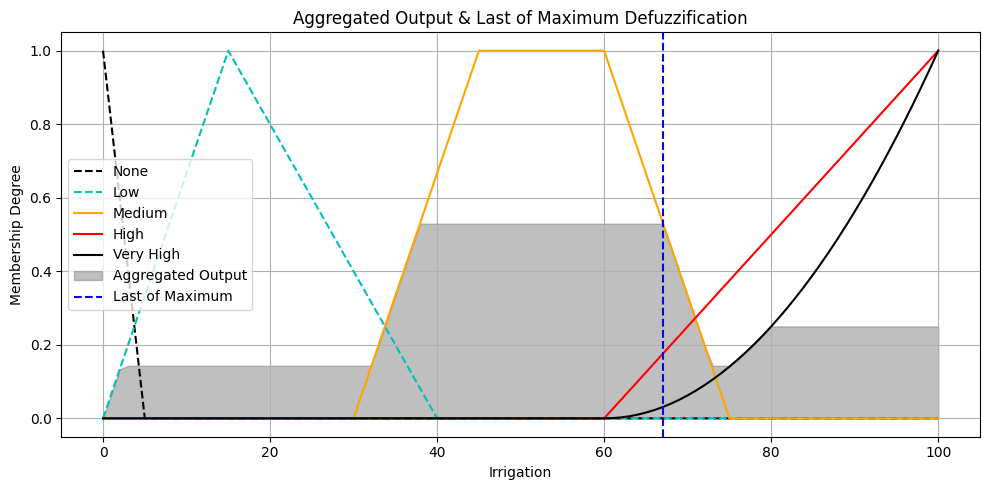

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_LM2, color='blue', linestyle='--', label='Last of Maximum')

plt.title('Aggregated Output & Last of Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### **Center Of The Surface**

In [83]:
crisp_output_bisector2 = fuzz.defuzz(irrigation.universe, aggregated_output, 'bisector')
print(f"\nFinal Irrigation Output (bisector): {crisp_output_bisector2:.2f}")


Final Irrigation Output (bisector): 54.23


###### **Visualization**

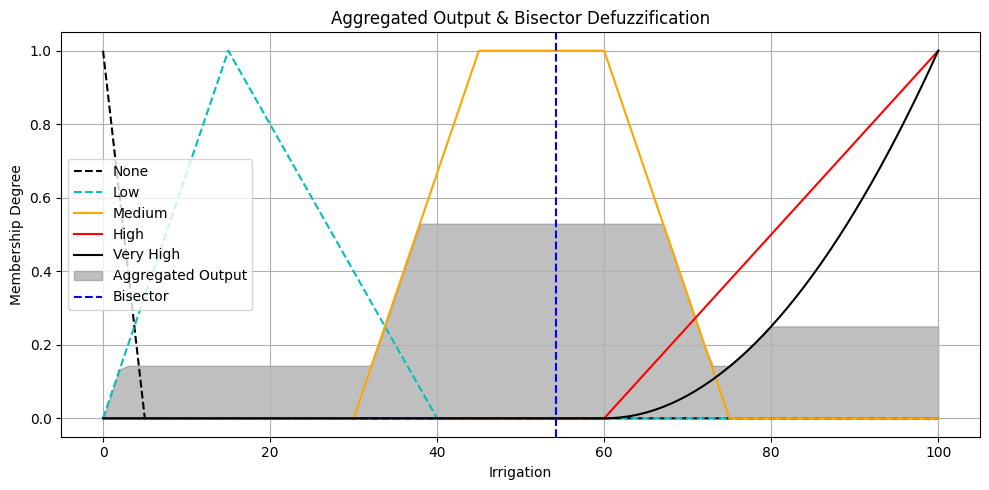

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_bisector2, color='blue', linestyle='--', label='Bisector')

plt.title('Aggregated Output & Bisector Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Simulation and Analysis**

#### **10 Day Timeframe**

Day 1: Weather=Sunny, Evap=-5.00, Soil Moisture=15.00% → 61.96%, Irrigation=86.60%
Day 2: Weather=Sunny, Evap=-5.00, Soil Moisture=61.96% → 71.20%, Irrigation=23.73%
Day 3: Weather=Cloudy, Evap=-2.00, Soil Moisture=71.20% → 78.19%, Irrigation=14.99%
Day 4: Weather=Rainy, Evap=5.00, Soil Moisture=78.19% → 84.20%, Irrigation=1.67%
Day 5: Weather=Sunny, Evap=-5.00, Soil Moisture=84.20% → 89.33%, Irrigation=16.88%
Day 6: Weather=Cloudy, Evap=-2.00, Soil Moisture=89.33% → 88.35%, Irrigation=1.71%
Day 7: Weather=Rainy, Evap=5.00, Soil Moisture=88.35% → 94.35%, Irrigation=1.67%
Day 8: Weather=Sunny, Evap=-5.00, Soil Moisture=94.35% → 99.71%, Irrigation=17.25%
Day 9: Weather=Cloudy, Evap=-2.00, Soil Moisture=99.71% → 98.83%, Irrigation=1.88%
Day 10: Weather=Rainy, Evap=5.00, Soil Moisture=98.83% → 100.00%, Irrigation=2.01%


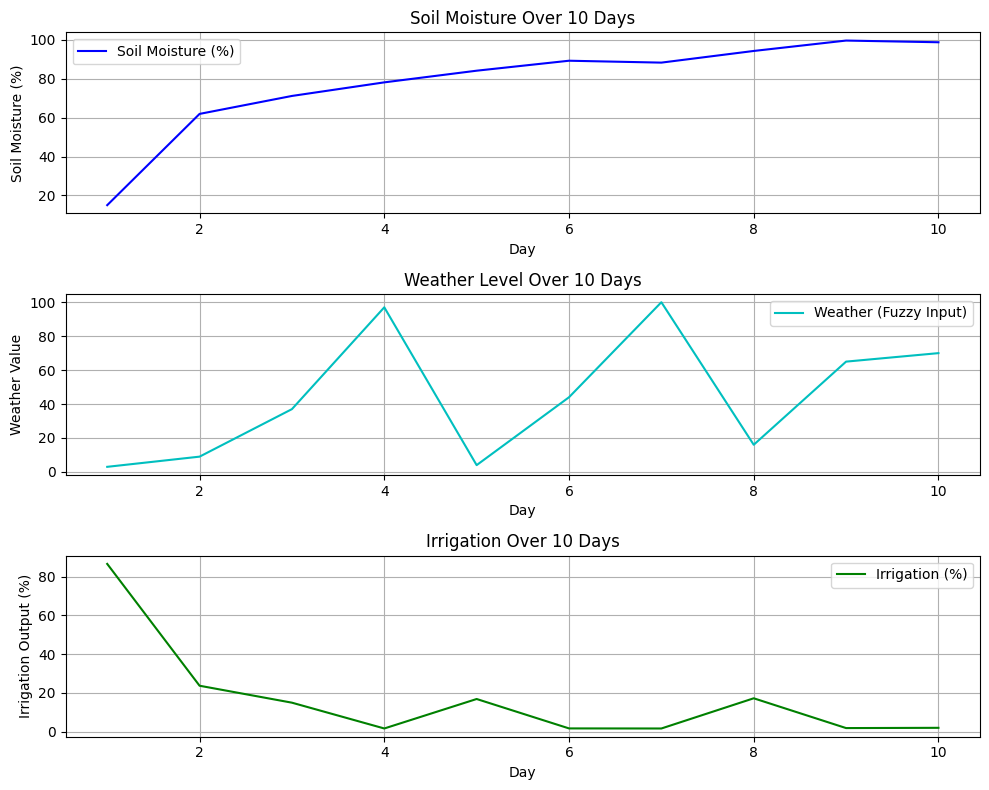

In [85]:
import random

days = 10
soil_moisture_values = [15]  # Initial soil moisture = 15%
weather_fuzzy = ["Sunny", "Sunny", "Cloudy", "Rainy", "Sunny", "Cloudy", "Rainy", "Sunny", "Cloudy", "Rainy"]
weather_values = []
irrigation_values = []

for day in range(days):
    if weather_fuzzy[day] == "Sunny":
        evap = -5
        weather_input = random.randint(0, 30)
    elif weather_fuzzy[day] == "Cloudy":
        evap = -2
        weather_input = random.randint(35, 65)
    else: # weather is rainy
        evap = +5
        weather_input = random.randint(70, 100)


    # Input to the fuzzy system
    soil_input = soil_moisture_values[day]
    weather_values.append(weather_input)

    irrigation_sim.input['soil'] = soil_input
    irrigation_sim.input['weather'] = weather_input
    irrigation_sim.compute()

    irrigation_amount = irrigation_sim.output['irrigation']
    irrigation_values.append(irrigation_amount)

    # Calculating new soil moisture using the modified equation
    new_moisture = soil_input + (irrigation_amount * 0.6) + evap
    new_moisture = np.clip(new_moisture, 0, 100)
    soil_moisture_values.append(new_moisture)

    # Print daily information
    print(f"Day {day+1}: Weather={weather_fuzzy[day]}, Evap={evap:.2f}, Soil Moisture={soil_input:.2f}% → {new_moisture:.2f}%, Irrigation={irrigation_amount:.2f}%")

# Drawing diagrams
days_axis = range(1, days + 1)
plt.figure(figsize=(10, 8))

# Soil moisture
plt.subplot(3, 1, 1)
plt.plot(days_axis, soil_moisture_values[:-1], 'b-', label='Soil Moisture (%)')
plt.title('Soil Moisture Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Soil Moisture (%)')
plt.grid(True)
plt.legend()

# Weather conditions in numbers
plt.subplot(3, 1, 2)
plt.plot(days_axis, weather_values, 'c-', label='Weather (Fuzzy Input)')
plt.title('Weather Level Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Weather Value')
plt.grid(True)
plt.legend()

# Irrigation
plt.subplot(3, 1, 3)
plt.plot(days_axis, irrigation_values, 'g-', label='Irrigation (%)')
plt.title('Irrigation Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Irrigation Output (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### **Analysis and Review**

In [86]:
# Define optimal, under, and over moisture zones
optimal_min = 40
optimal_max = 80

in_range_days = 0
under_moisture_days = 0
over_moisture_days = 0

# Categorize each day's moisture level
for moisture in soil_moisture_values[:-1]:  # Last value is t+1 and unused
    if optimal_min <= moisture <= optimal_max:
        in_range_days += 1
    elif moisture < optimal_min:
        under_moisture_days += 1
    elif moisture > optimal_max:
        over_moisture_days += 1

# Calculate percentages
success_rate = (in_range_days / days) * 100
under_rate = (under_moisture_days / days) * 100
over_rate = (over_moisture_days / days) * 100

# Display full performance analysis
print("\n📊 Detailed Performance Analysis:")
print(f"Optimal Moisture Range: {optimal_min}% to {optimal_max}%")
print(f"Days in Optimal Range: {in_range_days} ({success_rate:.2f}%)")
print(f"Days Under Optimal Range: {under_moisture_days} ({under_rate:.2f}%)")
print(f"Days Over Optimal Range: {over_moisture_days} ({over_rate:.2f}%)")

if over_rate > 40:
    print("This type of irrigation is recommended for greenhouses with high humidity.")
elif under_rate > 20:
    print("This type of irrigation is recommended for greenhouses with low humidity.")
else:
    print("The fuzzy controller maintains soil moisture efficiently within the desired range.")


📊 Detailed Performance Analysis:
Optimal Moisture Range: 40% to 80%
Days in Optimal Range: 3 (30.00%)
Days Under Optimal Range: 1 (10.00%)
Days Over Optimal Range: 6 (60.00%)
This type of irrigation is recommended for greenhouses with high humidity.


## **THE END**

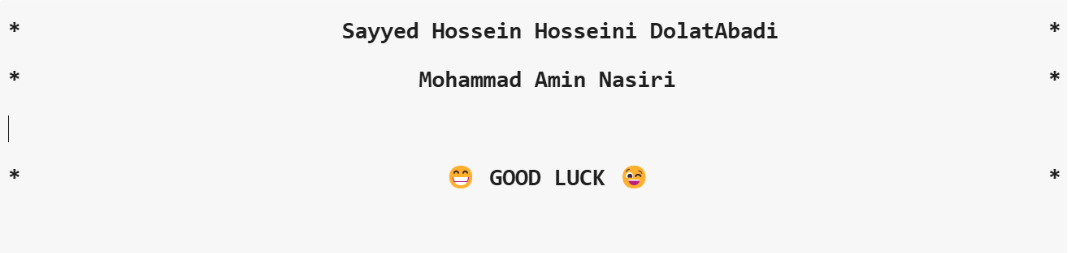